# Project : The price fluctuations of bitcoin

### (1) Loading local file into python environment

We have already excuted [Bitcoin_1_Download_Data.ipynb](https://github.com/LeiZHANG1995/PHBS_TQFML/blob/master/Project/Bitcoin_1_Download_Data.ipynb) file, and we have a [Bitcoin_data.csv](https://github.com/LeiZHANG1995/PHBS_TQFML/blob/master/Project/Bitcoin_data.csv) file under current path. Let's load the data into python environment:

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv("./Bitcoin_data.csv")
df.head()

,date,price,supply,capital,trade,wiki
0,2017-05-02,1452.076288,16307212.5,2.367932e+10,8.630647e+07,17143
1,2017-05-03,1507.576857,16308862.5,2.458686e+10,9.876808e+07,17277
2,2017-05-04,1508.292125,16310962.5,2.460170e+10,1.786810e+08,19238
3,2017-05-05,1533.335071,16312575.0,2.501264e+10,1.366548e+08,16900
4,2017-05-06,1560.410200,16314675.0,2.545759e+10,6.890728e+07,17793


First of all, we need to display the data, and to find some interesting features:

In [3]:
trade2 = df.trade / df.price
trade2.name = "trade2"

ln_price = np.log(df.price)
ln_trade = np.log(df.trade)
ln_trade2 = np.log(trade2)
ln_wiki = np.log(df.wiki)

### (2) Let's try to draw some patterns from the data

Now, we first generate an "interpreted" variable, `y`, from the `price` attribute of dataframe `df`. We map the current price of bitcoin into a binary variable, 1 for 'going up' and -1 for 'going down', compared with the previous price. 

Also, we extract the explanary variables from dataframe `df`, and store them into a numpy array. We want to figure out the relation pattern of 'up' and 'down' with those explanatory variables.

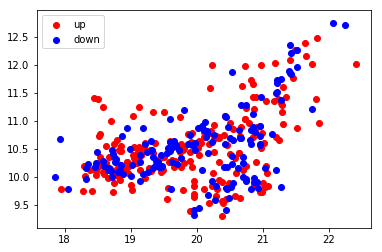

In [5]:
import matplotlib.pyplot as plt

y = df.price
y = y.diff()
y[y>0] = 1
y[y<0] = -1
y = y.values[1:len(y)-1]

attr1 = 'trade'
attr2 = 'wiki'

X = df.loc[0: len(y), [attr1, attr2]]

plt.scatter(np.log(X.loc[y>=0, attr1]).values, np.log(X.loc[y>=0, attr2]).values, c = 'r')
plt.scatter(np.log(X.loc[y<0, attr1]).values, np.log(X.loc[y<0, attr2]).values, c = 'b')
plt.legend(('up', 'down'), loc = 'best')
plt.show()

#### It seems we are in big trouble in predicting the price functuation!
Because there isn't any significant pattern that we are able to draw linearly from the figure above. It seems all the classical linear algorithms that we have learnt from the textbooks are invalid under this senario. We need to find some other ways to do prediction.

### (3) Using Time Series Models: ADL(autogressive dynamic lag) model

From the economietrics course, we know the best time series model in the viewfield of econometrics is ADL model, which is given is this form:

$$Y_t = \beta (1+L+L^2+...+L^{p-1})Y_{t-1}+\alpha (1+L+L^2+...+L^{p-1})X_{t-1}$$

ADL model may have a better performance in our case? Let find out. We have alredy written all the codes in the [LSTM.py](https://github.com/LeiZHANG1995/PHBS_TQFML/blob/master/Project/LSTM.py) file (please check the file and look through our algoriths and ideas), and here we just display the result.

First, we split the total data into training sample and test sample:

In [7]:
from LSTM import Predictor
from LSTM import Utils

X = pd.DataFrame({'ln_trade':ln_trade, 'ln_trade2':ln_trade2, 'ln_wiki':ln_wiki})
p = Predictor()

The accuracy for Pooled ADL : 

In [8]:
def ADL_Performance(sample_training, lag):
    train_set_X = X[:sample_training] 
    train_set_Y = ln_price[:sample_training]
    test_set_X = X[sample_training:]
    test_set_Y = ln_price[sample_training:]
    ## (1) Train pure ADL
    p.ADL_fit(train_set_Y, train_set_X, lag)
    re_train = p.ADL_predict_accuracy(train_set_Y, train_set_X, lag)
    train_accu = re_train['accuracy']
    ## (2) Test pure ADL
    re_test = p.ADL_predict_accuracy(test_set_Y, test_set_X, lag)
    test_accu =re_test['accuracy']
    return train_accu, test_accu

Find the optimal `lag` order

In [9]:
train_accus = []
test_accus = []
orders = []

sample_size = 200
# lag order differs

for i in range(1, 21):
    orders.append(i)
    t1, t2 = ADL_Performance(200, i)
    train_accus.append(t1)
    test_accus.append(t2)

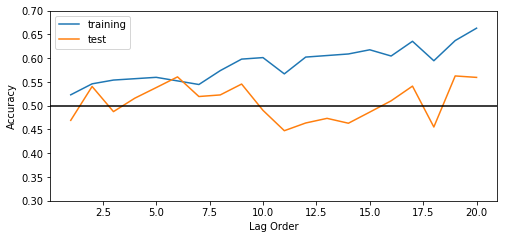

In [10]:
fig = plt.gcf()
fig.set_size_inches(8, 3.5)
plt.plot(orders, train_accus)
plt.plot(orders, test_accus)
plt.xlabel('Lag Order')
plt.ylabel('Accuracy')
plt.ylim([0.3, 0.7])
plt.axhline(0.5, color = 'black')
plt.legend(('training', 'test'))
plt.show()

Does this model sensitive to the training size? Let's find out.

In [11]:
train_accus = []
test_accus = []
samples = []
lag = 2

for s in range(150, 300):
    samples.append(s)
    t1, t2 = ADL_Performance(s, lag)
    train_accus.append(t1)
    test_accus.append(t2)

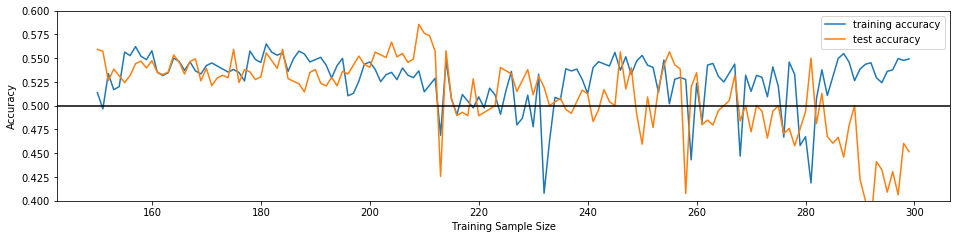

In [12]:
fig = plt.gcf()
fig.set_size_inches(16, 3.5)
plt.plot(samples, train_accus)
plt.plot(samples, test_accus)
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.ylim([0.4, 0.6])
plt.axhline(0.5, color = 'black')
plt.legend(('training accuracy', 'test accuracy'), loc = 'best')
plt.show()

### (4) Using LSTM (long and short term memory) Model

Now, let's use another method to do prediction. This method is inspired from the LSTM(long and short term memory) model, which is a hot deep learning topic. The idea is similar, so I name this method LSTM model.

We have written all the code of this method in [LSTM.py](https://github.com/LeiZHANG1995/PHBS_TQFML/blob/master/Project/LSTM.py) file, and here we just call the method and display the result.

In [13]:
def LSTM_performance(sample_training, window, lag):
    
    train_set_X = X[:sample_training] 
    train_set_Y = ln_price[:sample_training]
    test_set_X = X[sample_training:]
    test_set_Y = ln_price[sample_training:]
    
    train_re = p.LSTM_fit(train_set_Y, train_set_X, lag, window)
    
    nperf1 = np.array(train_re['ADL_accuracy'])
    nperf2 = np.array(train_re['LR_accuracy'])
    Avg_train_accu_adl = nperf1.mean()
    Avg_train_accu_lstm = nperf2.mean()
    
    test_re = p.LSTM_predict_accuracy(test_set_Y, test_set_X, lag, window)
    test_accu = test_re['accuracy']
    return Avg_train_accu_adl, Avg_train_accu_lstm, test_accu

Find the optimal `window`.

In [14]:
sample_training = 200
# window = differs
lag = 2

avg_train_accu_adl = []
avg_train_accu_lstm = []
test_accus = []
windows = []

for w in range(30, 70):
    windows.append(w)
    t1, t2, t3 = LSTM_performance(sample_training, w, lag)
    avg_train_accu_adl.append(t1)
    avg_train_accu_lstm.append(t2)
    test_accus.append(t3)

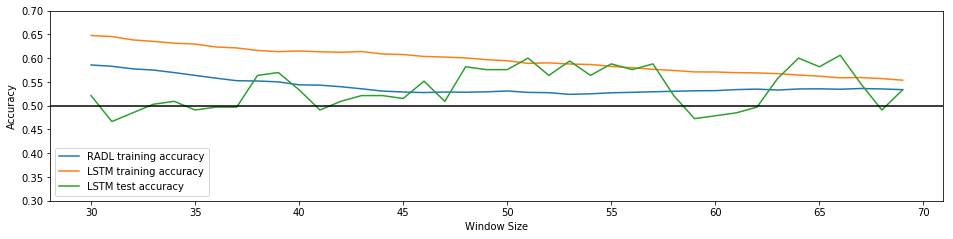

In [15]:
fig = plt.gcf()
fig.set_size_inches(16, 3.5)
plt.plot(windows, avg_train_accu_adl)
plt.plot(windows, avg_train_accu_lstm)
plt.plot(windows, test_accus)
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.ylim([0.3, 0.7])
plt.axhline(0.5, color = 'black')
plt.legend(('RADL training accuracy', 'LSTM training accuracy', 'LSTM test accuracy'))
plt.show()

Find the optimal `lag` order.

In [16]:
sample_training = 200
window = 50
# lag = differs

avg_train_accu_adl = []
avg_train_accu_lstm = []
test_accus = []
orders = []

for i in range(1, 9):
    orders.append(i)
    t1, t2, t3 = LSTM_performance(sample_training, window, i)
    avg_train_accu_adl.append(t1)
    avg_train_accu_lstm.append(t2)
    test_accus.append(t3)

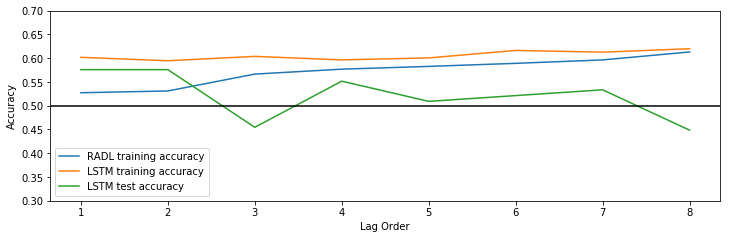

In [17]:
fig = plt.gcf()
fig.set_size_inches(12, 3.5)
plt.plot(orders, avg_train_accu_adl)
plt.plot(orders, avg_train_accu_lstm)
plt.plot(orders, test_accus)
plt.xlabel('Lag Order')
plt.ylabel('Accuracy')
plt.ylim([0.3, 0.7])
plt.axhline(0.5, color = 'black')
plt.legend(('RADL training accuracy', 'LSTM training accuracy', 'LSTM test accuracy'))
plt.show()

Does this result sensitive to the training size? Let's find out.

In [19]:
avg_train_accu_adl = []
avg_train_accu_lstm = []
test_accus = []
samples = []
window = 50
lag = 2

for s in range(150, 300):
    samples.append(s)
    t1, t2, t3 = LSTM_performance(s, window, lag)
    avg_train_accu_adl.append(t1)
    avg_train_accu_lstm.append(t2)
    test_accus.append(t3)

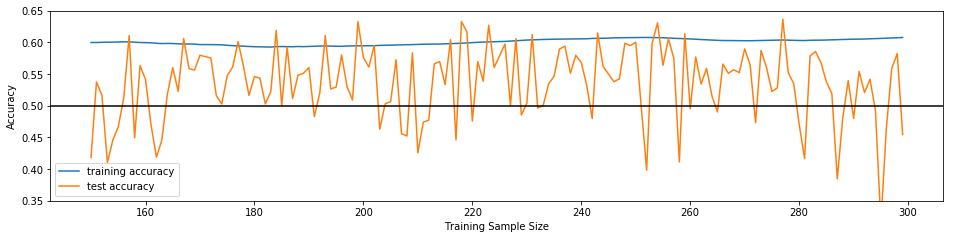

In [20]:
fig = plt.gcf()
fig.set_size_inches(16, 3.5)
plt.plot(samples, avg_train_accu_lstm)
plt.plot(samples, test_accus)
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.ylim([0.35, 0.65])
plt.axhline(0.5, color = 'black')
plt.legend(('training accuracy', 'test accuracy'), loc = 'best')
plt.show()

### (5) Conclusion

Pooled ADL is stationary, and does not face overfitting problem. But the accuracy is just a little bit higher than 0.5, which is not a good performance.

LSTM is very sensitive to the input parameters, and the model can be overfitting in many cases, but it predict well under some optimal parameters.